In [28]:
# imports
import pandas as pd
import dsbhelper
import numpy as np
from matplotlib import pyplot as plt
import cv2
from sklearn.cluster import KMeans
from sklearn import preprocessing
import random
import utils
import pylab

In [29]:
# get dpi for this machine to plot actual sized images
F = pylab.gcf()
DPI = F.get_dpi()
print(DPI)

72.0


In [15]:
# constants
CLASSES = 'classes.csv'
KFOLD_DATA = 'kfold_data.csv'
TRAIN = './stage1_train'
TEST = './stage1_test'

In [16]:
# get the basic specimen metadata
df = pd.read_csv(KFOLD_DATA)
df.head(5)

,filename,foreground,background,specimen_id,train_or_test,nuclei_count,area_min,area_max,area_mean,image_height,image_width,image_mean_intensity,image_violet_intensity
0,d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1...,white,black,d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1...,train,10,17.0,308.5,135.250000,256,256,5.940491,0
1,4596961c789d3b41916492918797724fe75128239fefc5...,white,black,4596961c789d3b41916492918797724fe75128239fefc5...,train,133,35.0,1183.5,588.537594,520,696,8.945875,0
2,b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39...,white,black,b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39...,train,25,47.0,4119.5,1175.160000,360,360,11.378356,0
3,831218e6a1a54b23d4be56c5799854e7eb978811b89215...,white,black,831218e6a1a54b23d4be56c5799854e7eb978811b89215...,train,20,14.0,2900.0,1427.100000,360,360,8.676682,0
4,b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845...,white,black,b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845...,train,22,13.5,243.0,99.000000,256,256,5.048172,0


<H2>Resize Nuclei to Average for the Population</H2>

In [139]:
train_specimen_ids = dsbhelper.get_specimen_ids(TRAIN)
specimen_id = random.choice(train_specimen_ids)
print (specimen_id)

52a4ac5a875be7a6c886035d54fb63f5f397dc43508c4831898f6b2f8debc7f3


(256, 256, 3)


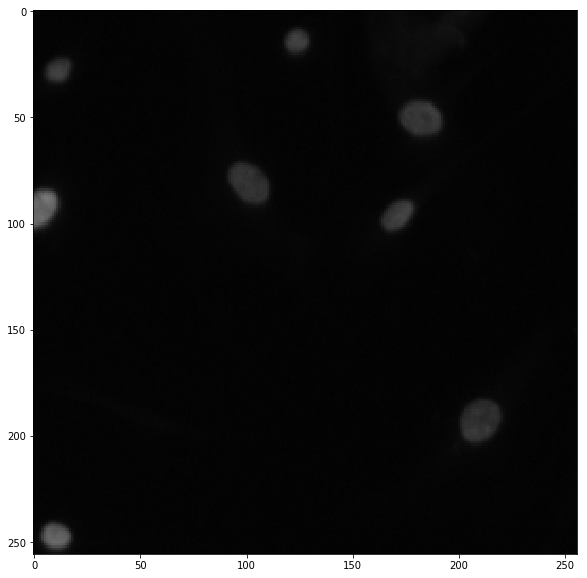

In [143]:
image = dsbhelper.get_specimen_image(TRAIN, specimen_id)
print(image.shape)
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
axarr.imshow(image)

(512, 512, 3)


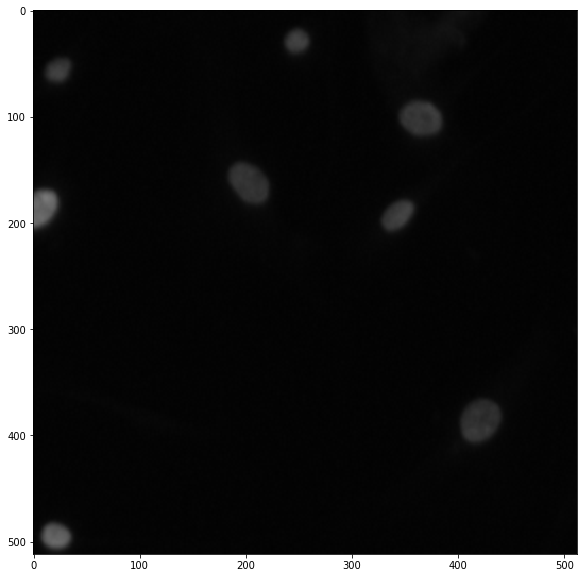

In [144]:
IMAGE_MIN_DIM = 512
IMAGE_MAX_DIM = 512
IMAGE_PADDING = True
resized_image, _, _, _ = utils.resize_image(image, min_dim=IMAGE_MIN_DIM, max_dim=IMAGE_MAX_DIM, padding=IMAGE_PADDING)
print(resized_image.shape)
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
axarr.imshow(resized_image)

In [155]:
def calc_population_stats(path):

    # constants
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_PADDING = True

    # initialize list to store areas
    areas = []
    
    # get training specimen list
    train_specimen_ids = dsbhelper.get_specimen_ids(path)
    #train_specimen_ids = ['52a4ac5a875be7a6c886035d54fb63f5f397dc43508c4831898f6b2f8debc7f3']
    
    # loop through each specimen_id, if its a training specimen, calculate the area of each mask
    for specimen_id in train_specimen_ids:
        masks = dsbhelper.get_specimen_masks(path, specimen_id)
        masks = np.asarray(masks)
        masks = np.moveaxis(masks, 0, 2)
        image = dsbhelper.get_specimen_image(path, specimen_id)
        _, _, scale, padding = utils.resize_image(image, min_dim=IMAGE_MIN_DIM, max_dim=IMAGE_MAX_DIM, padding=IMAGE_PADDING)
        masks = utils.resize_mask(masks, scale, padding)
        for i in range(masks.shape[-1]):
            rgb = cv2.cvtColor(masks[:, :, i], cv2.COLOR_GRAY2RGB)
            gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
            _, contours, _ = cv2.findContours(gray.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for j, contour in enumerate(contours):
                area = cv2.contourArea(contour)
                areas.append(area)
    
    # convert to numpy and return min, max, and mean
    areas = np.asarray(areas)
    
    return areas.min(), areas.max(), areas.mean()

# unit test ------------------------------------
pop_min, pop_max, pop_mean = calc_population_stats(TRAIN)
print('population min = {}'.format(pop_min))
print('population max = {}'.format(pop_max))
print('population mean = {}'.format(pop_mean))


/Users/farrar/py3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


population min = 0.0
population max = 17306.5
population mean = 682.5172356809994


In [42]:
def get_resize_metrics(path, specimen_id):

    areas = []

    pop_mean_nuclei_size = 425.391
    
    masks = dsbhelper.get_specimen_masks(path, specimen_id)
    shape_before = masks[0].shape

    for mask in masks:
        rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
        _, contours, _ = cv2.findContours(gray.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for j, contour in enumerate(contours):
            area = cv2.contourArea(contour)
            areas.append(area)

    areas = np.asarray(areas)
    specimen_mean_nuclei_size = areas.mean()
    print(specimen_mean_nuclei_size)
    
    resize_ratio = specimen_mean_nuclei_size / pop_mean_nuclei_size
    
    # note that shape after is reversed so that the dimensions are proper for passing to cv2.resize
    shape_after = (int(shape_before[1] * resize_ratio), int(shape_before[0] * resize_ratio))
    
    return resize_ratio, shape_before, shape_after

# unit test -------------------------------
train_specimen_ids = dsbhelper.get_specimen_ids(TRAIN)
specimen_id = random.choice(train_specimen_ids)
resize_ratio, shape_before, shape_after = get_resize_metrics(TRAIN, specimen_id)
print ('resize ratio -> {}'.format(resize_ratio))
print ('shape before -> {}'.format(shape_before))
print ('shape after  -> {}'.format(shape_after))

625.5166666666667
resize ratio -> 1.4704511065506007
shape before -> (520, 696)
shape after  -> (1023, 764)


In [43]:
image = dsbhelper.get_specimen_image(TRAIN, specimen_id)
resize = cv2.resize(image, shape_after, interpolation=cv2.INTER_CUBIC)
print(image.shape)
print(resize.shape)

(520, 696, 3)
(764, 1023, 3)


In [44]:
IMAGE_MIN_DIM = 512
IMAGE_MAX_DIM = 512
IMAGE_PADDING = True
molded_image, _, _, _ = utils.resize_image(image, min_dim=IMAGE_MIN_DIM, max_dim=IMAGE_MAX_DIM, padding=IMAGE_PADDING)
molded_resize, _, _, _ = utils.resize_image(resize, min_dim=IMAGE_MIN_DIM, max_dim=IMAGE_MAX_DIM, padding=IMAGE_PADDING)


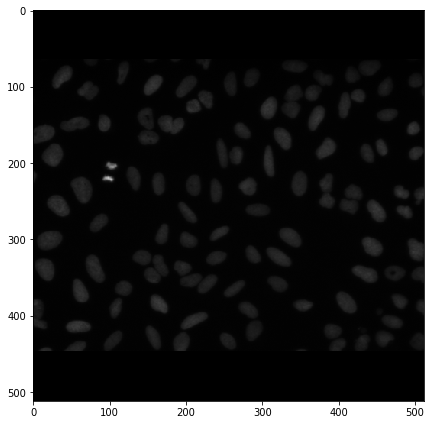

In [45]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(int(image.shape[0]/DPI), int(image.shape[1])/DPI))
axarr.imshow(molded_image)

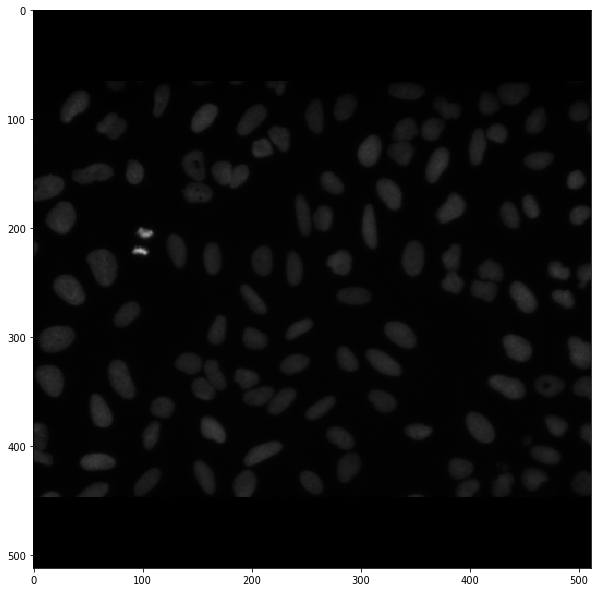

In [46]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(int(resize.shape[0]/DPI), int(resize.shape[1])/DPI))
axarr.imshow(molded_resize)

In [47]:
specimen_id = random.choice(train_specimen_ids)
resize_ratio, shape_before, shape_after = get_resize_metrics(TRAIN, specimen_id)
print ('resize ratio -> {}'.format(resize_ratio))
print ('shape before -> {}'.format(shape_before))
print ('shape after  -> {}'.format(shape_after))

333.1931818181818
resize ratio -> 0.7832633549327132
shape before -> (256, 256)
shape after  -> (200, 200)


In [48]:
image_2 = dsbhelper.get_specimen_image(TRAIN, specimen_id)
resize_2 = cv2.resize(image_2, shape_after, interpolation=cv2.INTER_CUBIC)
print(image_2.shape)
print(resize_2.shape)

(256, 256, 3)
(200, 200, 3)


In [49]:
molded_image_2, _, _, _ = utils.resize_image(image_2, min_dim=IMAGE_MIN_DIM, max_dim=IMAGE_MAX_DIM, padding=IMAGE_PADDING)
molded_resize_2, _, _, _ = utils.resize_image(resize_2, min_dim=IMAGE_MIN_DIM, max_dim=IMAGE_MAX_DIM, padding=IMAGE_PADDING)

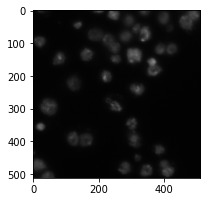

In [50]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(int(image_2.shape[0]/DPI), int(image_2.shape[1])/DPI))
axarr.imshow(molded_image_2)

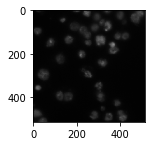

In [51]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(int(resize_2.shape[0]/DPI), int(resize_2.shape[1])/DPI))
axarr.imshow(molded_resize_2)

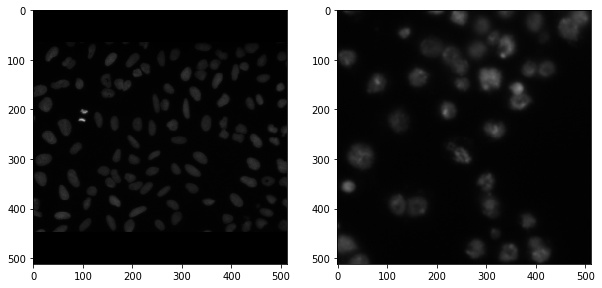

In [52]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(int(resize.shape[0]/DPI), int(resize.shape[1])/DPI))
axarr[0].imshow(molded_resize)
axarr[1].imshow(molded_resize_2)

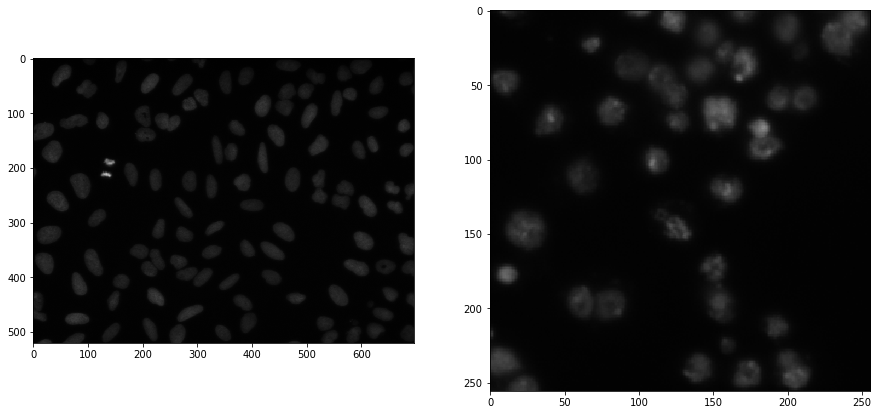

In [53]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
axarr[0].imshow(image)
axarr[1].imshow(image_2)